In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms 
from torchvision.utils import make_grid
import os 
import neurokit2 as nk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 
from tqdm import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

## Datasets and DataLoaders
Since the PyTorch DataLoader class constructs batches from a Dataset object, a custom ScalogramDataset class is created here. The ScalogramDataset() class has the following arguments
1. ```annotation_file``` : the ```REFERENCE.csv``` file which contains the record number and diagnosis category for each signal
2. ```img_dir``` : the image directory
3. ```split_index``` : an array containing indices for train test split since such a split was not done at a directory level
4. ```transform``` : transformations on the images

In [2]:
training_img_dir = './../signal_cwt_images_training/hamilton_filter/'
label_list = pd.read_csv('./../signal_cwt_images_training/REFERENCE.csv', index_col=[0])

idx = np.arange(0, 8528)
idx_train, idx_test = train_test_split(idx, test_size=0.2, shuffle=True, random_state=100) # random_state=100 for reproducibility

In [3]:
class ScalogramDataset(Dataset):
    ''' 
    The scalogram dataset is initialized with the REFERENCE.csv file, image directory and a list of 
    suitable transformations on the image dataset.

    In this form, the annotations_file is represented as a directory reference to the REFERENCE.csv file. The split index argument refers to
    the particular train/test split inside the image directory.
    '''
    def __init__(self, annotations_file, img_dir, split_index, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=[0]).iloc[split_index, :]
        self.img_dir = img_dir 
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0] + '.png'
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)[0:3, :, :].float() # by default, the image tensors are uint8; these are converted to floats
        label = self.img_labels.iloc[idx, 2] # the third column contains the encoded diagnoses

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label 

During data augmentation, a major transformation is *normalization* where each pixel in each channel is transformed via
$$ \widetilde{\rm{pixel}}_{\rm{R,G,B}} = \frac{\rm{pixel}_{\rm{R,G,B}} - \mu_{\rm{R,G,B}}}{\sigma_{\rm{R,G,B}}} $$
where $\mu_{\rm{R,G,B}}$ and $\sigma_{\rm{R,G,B}}$ are the means and standard deviations of the pixels in the R, G, B channels. This can be calculated through the pixel_stats() function. This yields
$$ \mu_{\rm{R,G,B}}=\left[ 5.06, 18.04, 160.67 \right] $$
and, 
$$ \sigma_{\rm{R,G,B}}=\left[ 30.72, 54.80, 54.35 \right] $$
The large value of $\mu_{\rm{B}}$ is unsurprising due to the color map chosen to represent the scalograms.

In [4]:
def pixel_stats(annotations_file, img_dir):
    img_labels = annotations_file.iloc[:,0] # dataframe converted into a series object here

    channel_sum = 0
    channel_squared_sum = 0

    for idx in range(len(img_labels)):
        img_file_name = img_labels[idx] + '.png'
        img_path = os.path.join(img_dir, img_file_name)
        img = read_image(img_path)[0:3, :, :].float()

        ''' 
        When the mean and standard deviation of the channels are calculated, the image matrix must be
        converted to the appropriate type using .float(). Otherwise, PyTorch will return an error message.
        '''
        channel_sum += torch.mean(img.float(), dim=[1, 2]) # dim=1,2 refer to the pixel axes only; returns a 1 x 3 tensor
        channel_squared_sum += torch.mean((img**2).float(), dim=[1,2])

    mean = channel_sum/len(img_labels)
    std = torch.sqrt(( channel_squared_sum/len(img_labels) - mean**2 ))

    return mean, std 

mean, std = pixel_stats(label_list, training_img_dir)
mean = mean.tolist()
std = std.tolist()
img_stats = (mean, std)

print(img_stats)

([5.061399459838867, 18.044464111328125, 160.6666717529297], [30.715213775634766, 54.7985725402832, 50.34616470336914])


For training, a batch sizes $64$ was used. For image augmentation, random crop, rotation and flipping are performed only on the training dataset. On both training and validation sets, however, the pixel normalization is performed. Moreover, they are resized to $3\times227\times227$ for training with AlexNet.

In [7]:
batch_size = 64

#img_stats = ((7.2307,  26.7144, 162.4496), (35.7087, 66.2034, 54.3562))
train_transform = transforms.Compose(
    [
        transforms.Resize(size=(227, 227)),
        transforms.RandomCrop(size=(227, 227), padding=4, padding_mode='reflect'),
        transforms.RandomRotation(degrees=(-45, 45)),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.1),
        transforms.Normalize(*img_stats, inplace=True)
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize(size=(227, 227)),
        transforms.Normalize(*img_stats, inplace=True)
    ]
)

train_ds = ScalogramDataset(
    './../signal_cwt_images_training/REFERENCE.csv',
    training_img_dir,
    idx_train,
    transform=train_transform
)

valid_ds = ScalogramDataset(
    './../signal_cwt_images_training/REFERENCE.csv',
    training_img_dir,
    idx_test,
    transform=valid_transform
)

print(f'Size of the train set {len(train_ds)}.')
print(f'Size of the test dataset is {len(valid_ds)}.')

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

Size of the train set 6822.
Size of the test dataset is 1706.


Sample images from training set 


Sample images from validation set 


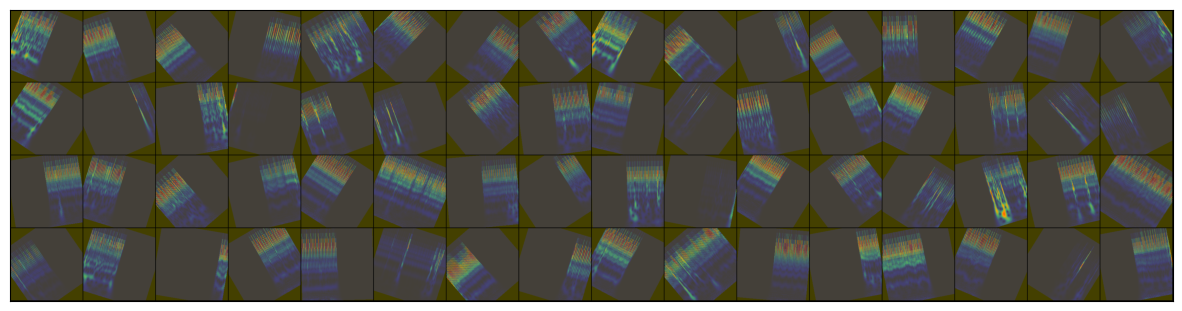

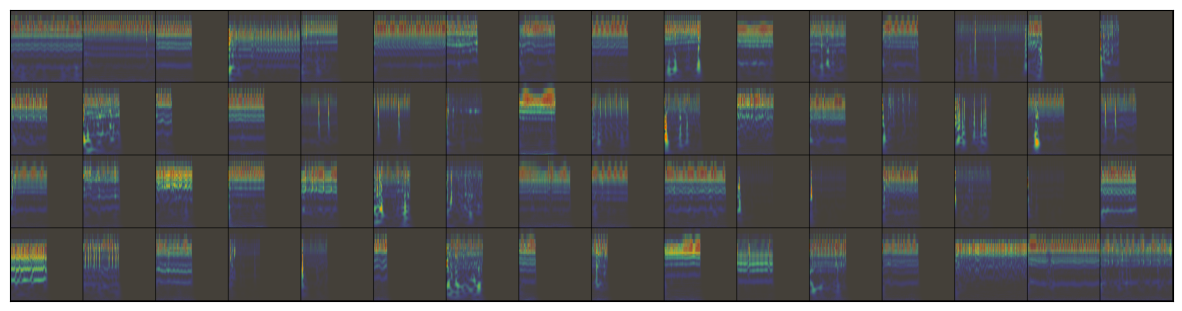

In [8]:
def show_batch(dataloader):
    for image, _ in dataloader:
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16, normalize=True).permute(1, 2, 0))
        break

print('Sample images from training set ')
show_batch(train_dl)
print('\n')
print('Sample images from validation set ')
show_batch(valid_dl)

## AlexNet

AlexNet is a CNN architecture that was designed by Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton as part of the $2012$ ImageNet challenge. The AlexNet architecture is shown below, where there is a sequence of five convolutional layers followed by three fully-connected linear layers. The input image is of the form $(3\times227\times227)$. Each convolutional layer has a BatchNorm layer. Moreover, the linear layers have Dropout layers with $p=0.5$. The BatchNorm and Dropout layers are there two minimize overfitting during training.
 
<img src='.\images\alexnet.png' class='center' width='600' height='400'>

All in all, the AlexNet architecture has approximately $60$ million learnable parameters. Hence, training on very large datasets becomes impractical without GPU acceleration. However, the ECG dataset in question is not very large. Nevertheless, training for $150$ epochs on this current CPU (without GPU and other parallelization) takes approximately $6$ hours. A PyTorch class for the AlexNet architecture is shown below where the initial image of shape $\mathcal{B}\times3\times227\times 227$ (where $\mathcal{B}$ is the batch size) is processed through the layers until an output of shape $\mathcal{B}\times 4$ is produced, where $4$ being the number of classes present.

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # Five convolutional layers

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0, bias=False),          # output shape : 96 x 55 x 55
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 96 x 27 x 27
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=False),         # output shape : 256 x 27 x 27
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 256 x 13 x 13
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, bias=False),        # output shape : 384 x 13 x 13
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, bias=False),        # output shape : 384 x 13 x 13
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, bias=False),        # output shape : 256 x 13 x 13
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)                           # output shape : 256 x 6 x 6
        )

        # Three fully connected layers; starting input shape is 256 x 6 x 6 = 9216

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(-1, 9216)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [10]:
model = AlexNet()

Training is performed over $150$ epochs with a learning rate scheduler. The ADAM optimizer is used with default parameters with $\eta_{\rm{max}}=10^{-3}$ and weight decay of $10^{-4}$ and the cross-entropy loss is used on this multiclass dataset.

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
   
def fit_one_cycle(num_epochs, max_lr, model, train_dl, valid_dl, loss_fn, opt_fun, weight_decay=0):
    '''
    Defining one complete cycle of training and validation over the specified number of epochs
    The function takes in the following parameters
    (1) number of epochs - num_epochs
    (2) maximum learning rate - max_lr
    (3) neural network model
    (4) training and validation/test dataloaders
    (5) regularization in terms of weigh decay (default set to 0)

    '''

    # instantiate optimizer with appropriate weight_decay
    optimizer = opt_fun(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr,
        epochs=num_epochs,
        steps_per_epoch=len(train_dl)
    )
    train_size = len(train_dl.dataset)
    valid_size = len(valid_dl.dataset)
    loss_train = [] # Loss history per epoch during training
    acc_train  = [] # Accuracy history per epoch during training
    loss_valid = [] # Loss history per epoch during validation
    acc_valid  = [] # Accuracy history per epoch during validation

    keys = ['epoch', 'training_loss', 'training_accuracy', 'validation_loss', 'validation_accuracy', 'last_lr']
    history = {key : [] for key in keys}    # initialize empty dictionary to store training and validation information and save as csv file 

    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        lrs = [] # for storing the adaptive learning rates per epoch

        for image, label in tqdm(train_dl, desc='Training loop'):
            
            '''  
            Calculate prediction and loss function per epoch
            '''
            output = model(image)
            loss = loss_fn(output, label)
            ''' 
            Backpropagating the loss function to re-adjust weights
            '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            '''
            Recording and updating learning rates
            '''
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()*image.size(0) # Accumulated loss per training batch
            _, predicted = torch.max(output, dim=1)
            running_total += label.size(0)
            running_correct += (predicted == label).sum().item()

        training_loss = running_loss/train_size
        loss_train.append(training_loss)
        training_accuracy = running_correct/running_total # Proportion of accurate predictions 
        acc_train.append(training_accuracy)
        '''
        Validation phase
        '''
        running_loss = 0.0
        running_correct = 0 # Keeps track of the number of correct classifications
        running_total = 0

        with torch.no_grad():
            for image, label in tqdm(valid_dl, desc='Validation loop'):
                model.eval()
                output = model(image)
                loss = loss_fn(output, label)
                
                running_loss += loss.item()*image.size(0) # Accumulated loss per validation batch
                _, predicted = torch.max(output, dim=1)
                running_total += label.size(0)
                running_correct += (predicted == label).sum().item()
        validation_loss = running_loss/valid_size 
        loss_valid.append(validation_loss)
        validation_accuracy = running_correct/running_total
        acc_valid.append(validation_accuracy)

        # Append information in csv file
        history['epoch'].append(epoch)
        history['training_accuracy'].append(training_accuracy)
        history['training_loss'].append(training_loss)
        history['validation_accuracy'].append(validation_accuracy)
        history['validation_loss'].append(validation_loss)
        history['last_lr'].append(lrs[-1])

        # Epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}: trainining loss = {training_loss:4f}, last_lr = {lrs[-1]}, training accuracy = {training_accuracy:4f},\
               validation loss = {validation_loss:4f}, validation accuracy = {validation_accuracy:4f}')
        
    history_df = pd.DataFrame.from_dict(history)
    history_df.to_csv('./../training_histories/history.csv')
    
    return loss_train, acc_train, loss_valid, acc_valid

In [12]:
num_epochs = 150
max_lr = 1.0e-3
weight_decay = 1.0e-4
opt_fun = torch.optim.Adam

loss_fn = nn.CrossEntropyLoss()

loss_train, acc_train, loss_valid, acc_valid = fit_one_cycle(
    num_epochs,
    max_lr,
    model,
    train_dl,
    valid_dl,
    loss_fn,
    opt_fun,
    weight_decay=weight_decay
)

Training loop:   0%|          | 0/107 [00:00<?, ?it/s]

Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch 1/150: trainining loss = 0.994561, last_lr = 4.1147988022792003e-05, training accuracy = 0.583846,               validation loss = 0.919547, validation accuracy = 0.611372


Validation loop: 100%|██████████| 27/27 [00:14<00:00,  1.86it/s]


Epoch 2/150: trainining loss = 0.886799, last_lr = 4.462976163203123e-05, training accuracy = 0.622691,               validation loss = 0.843569, validation accuracy = 0.639508


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 3/150: trainining loss = 0.815769, last_lr = 5.0428453142785596e-05, training accuracy = 0.652741,               validation loss = 0.768148, validation accuracy = 0.686401


Validation loop: 100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Epoch 4/150: trainining loss = 0.782653, last_lr = 5.851580017957969e-05, training accuracy = 0.668426,               validation loss = 0.726433, validation accuracy = 0.713365


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 5/150: trainining loss = 0.758369, last_lr = 6.88523856363076e-05, training accuracy = 0.674436,               validation loss = 0.727331, validation accuracy = 0.716295


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Epoch 6/150: trainining loss = 0.719885, last_lr = 8.138782979217013e-05, training accuracy = 0.698622,               validation loss = 0.723881, validation accuracy = 0.689918


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 7/150: trainining loss = 0.713150, last_lr = 9.606103585855076e-05, training accuracy = 0.697889,               validation loss = 0.758579, validation accuracy = 0.672333


Validation loop: 100%|██████████| 27/27 [00:12<00:00,  2.10it/s]


Epoch 8/150: trainining loss = 0.701943, last_lr = 0.00011280048776005427, training accuracy = 0.704339,               validation loss = 1.150823, validation accuracy = 0.553341


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Epoch 9/150: trainining loss = 0.693588, last_lr = 0.00013152459869834562, training accuracy = 0.708004,               validation loss = 0.826082, validation accuracy = 0.690504


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Epoch 10/150: trainining loss = 0.687778, last_lr = 0.00015214210879991696, training accuracy = 0.715626,               validation loss = 0.703223, validation accuracy = 0.720399


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 11/150: trainining loss = 0.695612, last_lr = 0.0001745525299096767, training accuracy = 0.710789,               validation loss = 0.669201, validation accuracy = 0.726260


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 12/150: trainining loss = 0.669640, last_lr = 0.0001986466353624725, training accuracy = 0.725447,               validation loss = 0.683866, validation accuracy = 0.711020


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 13/150: trainining loss = 0.660392, last_lr = 0.00022430699234543766, training accuracy = 0.726033,               validation loss = 0.677055, validation accuracy = 0.732122


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 14/150: trainining loss = 0.674812, last_lr = 0.0002514085342564702, training accuracy = 0.728086,               validation loss = 0.683729, validation accuracy = 0.725088


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 15/150: trainining loss = 0.668662, last_lr = 0.00027981917026921154, training accuracy = 0.727353,               validation loss = 0.745026, validation accuracy = 0.684642


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 16/150: trainining loss = 0.663278, last_lr = 0.00030940042913355273, training accuracy = 0.732630,               validation loss = 0.649900, validation accuracy = 0.730950


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 17/150: trainining loss = 0.653249, last_lr = 0.00034000813407383487, training accuracy = 0.736001,               validation loss = 0.736657, validation accuracy = 0.697538


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 18/150: trainining loss = 0.652284, last_lr = 0.00037149310549534063, training accuracy = 0.732776,               validation loss = 0.617827, validation accuracy = 0.750879


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 19/150: trainining loss = 0.641514, last_lr = 0.0004037018880741403, training accuracy = 0.738933,               validation loss = 0.596665, validation accuracy = 0.773740


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 20/150: trainining loss = 0.657118, last_lr = 0.0004364774986865134, training accuracy = 0.738200,               validation loss = 0.619607, validation accuracy = 0.753810


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 21/150: trainining loss = 0.652070, last_lr = 0.0004696601915325933, training accuracy = 0.733509,               validation loss = 0.637686, validation accuracy = 0.743259


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 22/150: trainining loss = 0.647138, last_lr = 0.000503088236725083, training accuracy = 0.739519,               validation loss = 0.630803, validation accuracy = 0.742087


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 23/150: trainining loss = 0.650881, last_lr = 0.0005365987085482604, training accuracy = 0.737907,               validation loss = 0.641137, validation accuracy = 0.757913


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 24/150: trainining loss = 0.634270, last_lr = 0.0005700282795453584, training accuracy = 0.745529,               validation loss = 0.968199, validation accuracy = 0.686401


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 25/150: trainining loss = 0.638925, last_lr = 0.000603214016564001, training accuracy = 0.739812,               validation loss = 0.939047, validation accuracy = 0.519343


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 26/150: trainining loss = 0.620016, last_lr = 0.0006359941748798283, training accuracy = 0.749194,               validation loss = 0.955620, validation accuracy = 0.681125


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 27/150: trainining loss = 0.631342, last_lr = 0.0006682089865278181, training accuracy = 0.748754,               validation loss = 0.785365, validation accuracy = 0.646542


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 28/150: trainining loss = 0.644034, last_lr = 0.0006997014389990308, training accuracy = 0.738493,               validation loss = 0.684773, validation accuracy = 0.735053


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 29/150: trainining loss = 0.615382, last_lr = 0.0007303180405074777, training accuracy = 0.755204,               validation loss = 0.642357, validation accuracy = 0.742673


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 30/150: trainining loss = 0.625121, last_lr = 0.0007599095680972537, training accuracy = 0.749634,               validation loss = 0.734689, validation accuracy = 0.682884


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 31/150: trainining loss = 0.630803, last_lr = 0.0007883317949437233, training accuracy = 0.743917,               validation loss = 0.711735, validation accuracy = 0.674091


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 32/150: trainining loss = 0.622581, last_lr = 0.0008154461933039479, training accuracy = 0.750366,               validation loss = 1.024989, validation accuracy = 0.583236


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 33/150: trainining loss = 0.627274, last_lr = 0.0008411206096902259, training accuracy = 0.750073,               validation loss = 0.680041, validation accuracy = 0.734467


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Epoch 34/150: trainining loss = 0.619134, last_lr = 0.0008652299089760077, training accuracy = 0.751539,               validation loss = 0.662434, validation accuracy = 0.720985


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 35/150: trainining loss = 0.615256, last_lr = 0.0008876565842948556, training accuracy = 0.751686,               validation loss = 0.589952, validation accuracy = 0.757327


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 36/150: trainining loss = 0.614609, last_lr = 0.0009082913297598548, training accuracy = 0.748461,               validation loss = 0.934190, validation accuracy = 0.589683


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 37/150: trainining loss = 0.613241, last_lr = 0.0009270335732120812, training accuracy = 0.751686,               validation loss = 0.687458, validation accuracy = 0.740914


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 38/150: trainining loss = 0.623502, last_lr = 0.0009437919664015513, training accuracy = 0.743917,               validation loss = 0.693888, validation accuracy = 0.727433


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 39/150: trainining loss = 0.625761, last_lr = 0.0009584848302115527, training accuracy = 0.748607,               validation loss = 0.778370, validation accuracy = 0.685229


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 40/150: trainining loss = 0.624893, last_lr = 0.0009710405527563629, training accuracy = 0.753738,               validation loss = 0.597738, validation accuracy = 0.766706


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 41/150: trainining loss = 0.613614, last_lr = 0.0009813979384120605, training accuracy = 0.756376,               validation loss = 0.603226, validation accuracy = 0.762016


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Epoch 42/150: trainining loss = 0.612375, last_lr = 0.0009895065060792796, training accuracy = 0.757842,               validation loss = 0.726074, validation accuracy = 0.733880


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 43/150: trainining loss = 0.602119, last_lr = 0.0009953267352241976, training accuracy = 0.761360,               validation loss = 0.766087, validation accuracy = 0.675264


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


Epoch 44/150: trainining loss = 0.601820, last_lr = 0.00099883025849857, training accuracy = 0.760188,               validation loss = 0.625392, validation accuracy = 0.748535


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


Epoch 45/150: trainining loss = 0.596433, last_lr = 0.001, training accuracy = 0.761360,               validation loss = 0.628631, validation accuracy = 0.750879


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 46/150: trainining loss = 0.599015, last_lr = 0.0009997762170368871, training accuracy = 0.761360,               validation loss = 0.645221, validation accuracy = 0.742673


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.37it/s]


Epoch 47/150: trainining loss = 0.596619, last_lr = 0.000999105068463608, training accuracy = 0.756670,               validation loss = 0.619512, validation accuracy = 0.752638


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 48/150: trainining loss = 0.590135, last_lr = 0.0009979871550490316, training accuracy = 0.762093,               validation loss = 0.803064, validation accuracy = 0.710434


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 49/150: trainining loss = 0.585450, last_lr = 0.000996423477477066, training accuracy = 0.765172,               validation loss = 0.854169, validation accuracy = 0.699883


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 50/150: trainining loss = 0.588161, last_lr = 0.0009944154354509117, training accuracy = 0.773967,               validation loss = 0.603549, validation accuracy = 0.768464


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 51/150: trainining loss = 0.595207, last_lr = 0.0009919648264401376, training accuracy = 0.766931,               validation loss = 0.602159, validation accuracy = 0.756741


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 52/150: trainining loss = 0.578730, last_lr = 0.0009890738440717015, training accuracy = 0.772354,               validation loss = 0.662258, validation accuracy = 0.703400


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 53/150: trainining loss = 0.584738, last_lr = 0.0009857450761663572, training accuracy = 0.768836,               validation loss = 0.802683, validation accuracy = 0.629543


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 54/150: trainining loss = 0.575727, last_lr = 0.0009819815024222052, training accuracy = 0.773087,               validation loss = 0.637032, validation accuracy = 0.755569


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 55/150: trainining loss = 0.580913, last_lr = 0.0009777864917474587, training accuracy = 0.770302,               validation loss = 0.912476, validation accuracy = 0.573271


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 56/150: trainining loss = 0.583587, last_lr = 0.0009731637992448144, training accuracy = 0.767663,               validation loss = 0.614656, validation accuracy = 0.762016


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 57/150: trainining loss = 0.578157, last_lr = 0.0009681175628501272, training accuracy = 0.769569,               validation loss = 0.580913, validation accuracy = 0.761430


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 58/150: trainining loss = 0.571257, last_lr = 0.0009626522996283973, training accuracy = 0.775872,               validation loss = 0.576597, validation accuracy = 0.790152


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 59/150: trainining loss = 0.561255, last_lr = 0.000956772901730385, training accuracy = 0.776752,               validation loss = 0.567518, validation accuracy = 0.780188


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 60/150: trainining loss = 0.573776, last_lr = 0.0009504846320134736, training accuracy = 0.773967,               validation loss = 0.608090, validation accuracy = 0.759086


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 61/150: trainining loss = 0.554951, last_lr = 0.000943793119330699, training accuracy = 0.781149,               validation loss = 0.572397, validation accuracy = 0.770809


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


Epoch 62/150: trainining loss = 0.560701, last_lr = 0.0009367043534921636, training accuracy = 0.777485,               validation loss = 0.581440, validation accuracy = 0.774912


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Epoch 63/150: trainining loss = 0.566448, last_lr = 0.0009292246799033457, training accuracy = 0.771328,               validation loss = 0.604886, validation accuracy = 0.760844


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 64/150: trainining loss = 0.559430, last_lr = 0.0009213607938851022, training accuracy = 0.779977,               validation loss = 0.728797, validation accuracy = 0.671161


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 65/150: trainining loss = 0.548802, last_lr = 0.0009131197346804487, training accuracy = 0.780856,               validation loss = 0.682247, validation accuracy = 0.769637


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 66/150: trainining loss = 0.551799, last_lr = 0.0009045088791534849, training accuracy = 0.781149,               validation loss = 0.666382, validation accuracy = 0.744431


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 67/150: trainining loss = 0.553404, last_lr = 0.0008955359351861013, training accuracy = 0.787013,               validation loss = 0.561944, validation accuracy = 0.774912


Validation loop: 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Epoch 68/150: trainining loss = 0.552897, last_lr = 0.0008862089347783812, training accuracy = 0.788478,               validation loss = 0.659847, validation accuracy = 0.727433


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 69/150: trainining loss = 0.546850, last_lr = 0.0008765362268588734, training accuracy = 0.783201,               validation loss = 0.593907, validation accuracy = 0.770223


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 70/150: trainining loss = 0.551659, last_lr = 0.0008665264698111694, training accuracy = 0.784667,               validation loss = 0.671615, validation accuracy = 0.688746


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 71/150: trainining loss = 0.548649, last_lr = 0.0008561886237234784, training accuracy = 0.783934,               validation loss = 0.674776, validation accuracy = 0.752638


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 72/150: trainining loss = 0.535937, last_lr = 0.0008455319423681343, training accuracy = 0.785840,               validation loss = 0.625314, validation accuracy = 0.765533


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 73/150: trainining loss = 0.535305, last_lr = 0.0008345659649182163, training accuracy = 0.789798,               validation loss = 0.723633, validation accuracy = 0.683470


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 74/150: trainining loss = 0.544075, last_lr = 0.0008233005074086972, training accuracy = 0.786426,               validation loss = 0.569271, validation accuracy = 0.784877


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch 75/150: trainining loss = 0.539746, last_lr = 0.000811745653949763, training accuracy = 0.789211,               validation loss = 0.928542, validation accuracy = 0.583236


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 76/150: trainining loss = 0.519422, last_lr = 0.0007999117477001673, training accuracy = 0.799179,               validation loss = 0.756801, validation accuracy = 0.681712


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


Epoch 77/150: trainining loss = 0.531567, last_lr = 0.0007878093816087053, training accuracy = 0.791117,               validation loss = 0.565030, validation accuracy = 0.789566


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


Epoch 78/150: trainining loss = 0.532618, last_lr = 0.0007754493889320882, training accuracy = 0.791850,               validation loss = 0.575080, validation accuracy = 0.778429


Validation loop: 100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Epoch 79/150: trainining loss = 0.522993, last_lr = 0.0007628428335377126, training accuracy = 0.792583,               validation loss = 0.569516, validation accuracy = 0.785463


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 80/150: trainining loss = 0.520470, last_lr = 0.0007500009999999999, training accuracy = 0.790677,               validation loss = 0.767442, validation accuracy = 0.626026


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 81/150: trainining loss = 0.518190, last_lr = 0.0007369353834991743, training accuracy = 0.796101,               validation loss = 0.733268, validation accuracy = 0.706917


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 82/150: trainining loss = 0.516455, last_lr = 0.0007236576795315195, training accuracy = 0.798886,               validation loss = 0.615021, validation accuracy = 0.774912


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


Epoch 83/150: trainining loss = 0.516737, last_lr = 0.0007101797734403261, training accuracy = 0.800498,               validation loss = 0.841252, validation accuracy = 0.621336


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 84/150: trainining loss = 0.508793, last_lr = 0.0006965137297768985, training accuracy = 0.800938,               validation loss = 0.555788, validation accuracy = 0.787222


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 85/150: trainining loss = 0.509429, last_lr = 0.0006826717815011488, training accuracy = 0.799765,               validation loss = 0.571059, validation accuracy = 0.788980


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 86/150: trainining loss = 0.505061, last_lr = 0.0006686663190314402, training accuracy = 0.803577,               validation loss = 0.551094, validation accuracy = 0.775498


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 87/150: trainining loss = 0.507486, last_lr = 0.0006545098791534849, training accuracy = 0.799472,               validation loss = 0.598112, validation accuracy = 0.783705


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 88/150: trainining loss = 0.503067, last_lr = 0.0006402151337982227, training accuracy = 0.800498,               validation loss = 0.559847, validation accuracy = 0.788394


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 89/150: trainining loss = 0.484719, last_lr = 0.0006257948786987268, training accuracy = 0.810026,               validation loss = 0.554820, validation accuracy = 0.768464


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 90/150: trainining loss = 0.493828, last_lr = 0.0006112620219362892, training accuracy = 0.807974,               validation loss = 0.606698, validation accuracy = 0.782532


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 91/150: trainining loss = 0.491903, last_lr = 0.0005966295723859409, training accuracy = 0.807534,               validation loss = 0.558949, validation accuracy = 0.783705


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 92/150: trainining loss = 0.484213, last_lr = 0.0005819106280717459, training accuracy = 0.811639,               validation loss = 0.652330, validation accuracy = 0.766706


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 93/150: trainining loss = 0.479018, last_lr = 0.000567118364442296, training accuracy = 0.812665,               validation loss = 0.627727, validation accuracy = 0.785463


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 94/150: trainining loss = 0.480526, last_lr = 0.0005522660225769001, training accuracy = 0.811932,               validation loss = 0.541661, validation accuracy = 0.796014


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 95/150: trainining loss = 0.469487, last_lr = 0.0005373668973330249, training accuracy = 0.818675,               validation loss = 0.541894, validation accuracy = 0.796600


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 96/150: trainining loss = 0.467908, last_lr = 0.0005224343254455967, training accuracy = 0.818089,               validation loss = 0.559524, validation accuracy = 0.800117


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 97/150: trainining loss = 0.468914, last_lr = 0.0005074816735888177, training accuracy = 0.813544,               validation loss = 0.542988, validation accuracy = 0.799531


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 98/150: trainining loss = 0.458698, last_lr = 0.0004925223264111823, training accuracy = 0.818089,               validation loss = 0.599960, validation accuracy = 0.767292


Validation loop: 100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Epoch 99/150: trainining loss = 0.453913, last_lr = 0.0004775696745544034, training accuracy = 0.819994,               validation loss = 0.567500, validation accuracy = 0.797186


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 100/150: trainining loss = 0.453100, last_lr = 0.00046263710266697503, training accuracy = 0.825858,               validation loss = 0.660947, validation accuracy = 0.779015


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 101/150: trainining loss = 0.462081, last_lr = 0.0004477379774230999, training accuracy = 0.819701,               validation loss = 0.533683, validation accuracy = 0.795428


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 102/150: trainining loss = 0.441361, last_lr = 0.00043288563555770405, training accuracy = 0.826297,               validation loss = 0.559720, validation accuracy = 0.787808


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 103/150: trainining loss = 0.437500, last_lr = 0.00041809337192825395, training accuracy = 0.829669,               validation loss = 0.537241, validation accuracy = 0.804220


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Epoch 104/150: trainining loss = 0.435472, last_lr = 0.00040337442761405903, training accuracy = 0.828203,               validation loss = 0.549735, validation accuracy = 0.796014


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s]


Epoch 105/150: trainining loss = 0.436097, last_lr = 0.00038874197806371076, training accuracy = 0.830108,               validation loss = 0.532441, validation accuracy = 0.804220


Validation loop: 100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch 106/150: trainining loss = 0.430428, last_lr = 0.00037420912130127325, training accuracy = 0.828496,               validation loss = 0.551230, validation accuracy = 0.802462


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Epoch 107/150: trainining loss = 0.431337, last_lr = 0.0003597888662017773, training accuracy = 0.833920,               validation loss = 0.531724, validation accuracy = 0.796600


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


Epoch 108/150: trainining loss = 0.421970, last_lr = 0.0003454941208465151, training accuracy = 0.836118,               validation loss = 0.589530, validation accuracy = 0.793669


Validation loop: 100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch 109/150: trainining loss = 0.412754, last_lr = 0.00033133768096855977, training accuracy = 0.838024,               validation loss = 0.588141, validation accuracy = 0.806565


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 110/150: trainining loss = 0.417152, last_lr = 0.0003173322184988512, training accuracy = 0.834946,               validation loss = 0.531371, validation accuracy = 0.806565


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Epoch 111/150: trainining loss = 0.403259, last_lr = 0.00030349027022310155, training accuracy = 0.839490,               validation loss = 0.521356, validation accuracy = 0.808910


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.37it/s]


Epoch 112/150: trainining loss = 0.408516, last_lr = 0.00028982422655967396, training accuracy = 0.845646,               validation loss = 0.530598, validation accuracy = 0.801290


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Epoch 113/150: trainining loss = 0.413342, last_lr = 0.00027634632046848027, training accuracy = 0.837731,               validation loss = 0.526634, validation accuracy = 0.803634


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


Epoch 114/150: trainining loss = 0.403097, last_lr = 0.00026306861650082563, training accuracy = 0.843594,               validation loss = 0.533517, validation accuracy = 0.807737


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


Epoch 115/150: trainining loss = 0.397536, last_lr = 0.0002500030000000001, training accuracy = 0.841249,               validation loss = 0.631767, validation accuracy = 0.796014


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


Epoch 116/150: trainining loss = 0.389397, last_lr = 0.00023716116646228723, training accuracy = 0.849604,               validation loss = 0.560214, validation accuracy = 0.807151


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Epoch 117/150: trainining loss = 0.380236, last_lr = 0.0002245546110679117, training accuracy = 0.848871,               validation loss = 0.559910, validation accuracy = 0.805393


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Epoch 118/150: trainining loss = 0.382726, last_lr = 0.00021219461839129468, training accuracy = 0.851950,               validation loss = 0.533993, validation accuracy = 0.803048


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Epoch 119/150: trainining loss = 0.374763, last_lr = 0.00020009225229983247, training accuracy = 0.854588,               validation loss = 0.584029, validation accuracy = 0.783118


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Epoch 120/150: trainining loss = 0.370042, last_lr = 0.00018825834605023698, training accuracy = 0.855028,               validation loss = 0.559664, validation accuracy = 0.800117


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Epoch 121/150: trainining loss = 0.367248, last_lr = 0.0001767034925913027, training accuracy = 0.853122,               validation loss = 0.572341, validation accuracy = 0.808910


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Epoch 122/150: trainining loss = 0.361731, last_lr = 0.00016543803508178376, training accuracy = 0.856347,               validation loss = 0.577373, validation accuracy = 0.804807


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch 123/150: trainining loss = 0.359818, last_lr = 0.00015447205763186565, training accuracy = 0.858253,               validation loss = 0.571475, validation accuracy = 0.811841


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 124/150: trainining loss = 0.357889, last_lr = 0.0001438153762765216, training accuracy = 0.857373,               validation loss = 0.604775, validation accuracy = 0.787808


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 125/150: trainining loss = 0.347418, last_lr = 0.00013347753018883065, training accuracy = 0.861624,               validation loss = 0.583395, validation accuracy = 0.811254


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch 126/150: trainining loss = 0.351142, last_lr = 0.00012346777314112658, training accuracy = 0.864409,               validation loss = 0.561941, validation accuracy = 0.808910


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 127/150: trainining loss = 0.341134, last_lr = 0.00011379506522161879, training accuracy = 0.868807,               validation loss = 0.576754, validation accuracy = 0.799531


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Epoch 128/150: trainining loss = 0.337076, last_lr = 0.00010446806481389881, training accuracy = 0.872618,               validation loss = 0.556435, validation accuracy = 0.804807


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 129/150: trainining loss = 0.322229, last_lr = 9.549512084651507e-05, training accuracy = 0.872765,               validation loss = 0.591726, validation accuracy = 0.787808


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 130/150: trainining loss = 0.325660, last_lr = 8.688426531955123e-05, training accuracy = 0.872618,               validation loss = 0.577356, validation accuracy = 0.805393


Validation loop: 100%|██████████| 27/27 [00:12<00:00,  2.21it/s]


Epoch 131/150: trainining loss = 0.311904, last_lr = 7.864320611489772e-05, training accuracy = 0.877455,               validation loss = 0.607932, validation accuracy = 0.804220


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 132/150: trainining loss = 0.315764, last_lr = 7.077932009665415e-05, training accuracy = 0.876283,               validation loss = 0.598302, validation accuracy = 0.806565


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 133/150: trainining loss = 0.311288, last_lr = 6.32996465078364e-05, training accuracy = 0.879654,               validation loss = 0.592749, validation accuracy = 0.806565


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 134/150: trainining loss = 0.313875, last_lr = 5.6210880669300965e-05, training accuracy = 0.877016,               validation loss = 0.604886, validation accuracy = 0.807737


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 135/150: trainining loss = 0.315970, last_lr = 4.9519367986526286e-05, training accuracy = 0.878481,               validation loss = 0.598282, validation accuracy = 0.810082


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 136/150: trainining loss = 0.296896, last_lr = 4.3231098269614797e-05, training accuracy = 0.881120,               validation loss = 0.618104, validation accuracy = 0.809496


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 137/150: trainining loss = 0.302257, last_lr = 3.73517003716026e-05, training accuracy = 0.884491,               validation loss = 0.597871, validation accuracy = 0.809496


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Epoch 138/150: trainining loss = 0.299490, last_lr = 3.1886437149872676e-05, training accuracy = 0.884345,               validation loss = 0.603125, validation accuracy = 0.808910


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Epoch 139/150: trainining loss = 0.298977, last_lr = 2.6840200755185466e-05, training accuracy = 0.882879,               validation loss = 0.605391, validation accuracy = 0.809496


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 140/150: trainining loss = 0.297198, last_lr = 2.2217508252541176e-05, training accuracy = 0.883172,               validation loss = 0.599201, validation accuracy = 0.805393


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.29it/s]


Epoch 141/150: trainining loss = 0.297076, last_lr = 1.8022497577794767e-05, training accuracy = 0.881120,               validation loss = 0.604093, validation accuracy = 0.803048


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 142/150: trainining loss = 0.294259, last_lr = 1.4258923833642831e-05, training accuracy = 0.885957,               validation loss = 0.608831, validation accuracy = 0.802462


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 143/150: trainining loss = 0.285337, last_lr = 1.0930155928298623e-05, training accuracy = 0.888009,               validation loss = 0.614036, validation accuracy = 0.811254


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Epoch 144/150: trainining loss = 0.282916, last_lr = 8.039173559862363e-06, training accuracy = 0.890794,               validation loss = 0.619126, validation accuracy = 0.803048


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Epoch 145/150: trainining loss = 0.282678, last_lr = 5.588564549088189e-06, training accuracy = 0.891088,               validation loss = 0.620194, validation accuracy = 0.804807


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Epoch 146/150: trainining loss = 0.288690, last_lr = 3.580522522934006e-06, training accuracy = 0.885517,               validation loss = 0.618075, validation accuracy = 0.808910


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


Epoch 147/150: trainining loss = 0.283428, last_lr = 2.016844950968456e-06, training accuracy = 0.890648,               validation loss = 0.618264, validation accuracy = 0.805393


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Epoch 148/150: trainining loss = 0.292208, last_lr = 8.989315363919581e-07, training accuracy = 0.886690,               validation loss = 0.611639, validation accuracy = 0.812427


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.41it/s]


Epoch 149/150: trainining loss = 0.290641, last_lr = 2.277829631129057e-07, training accuracy = 0.888889,               validation loss = 0.613610, validation accuracy = 0.809496


Validation loop: 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]

Epoch 150/150: trainining loss = 0.277505, last_lr = 4e-09, training accuracy = 0.896365,               validation loss = 0.614683, validation accuracy = 0.810668


Over $150$ epochs, it can be seen that AlexNet performs relatively well, with the prediction accuracy saturating to $\sim 81\%$ for $\mathcal{B}=64$ with signs of overfitting after the $100^\text{th}$ epoch. Moreover, we notice that the validation loss and accuracy curves display a lot of variation epoch-to-epoch, at least until epoch $125$. This maybe attributed to the inherent class imbalance in the dataset.

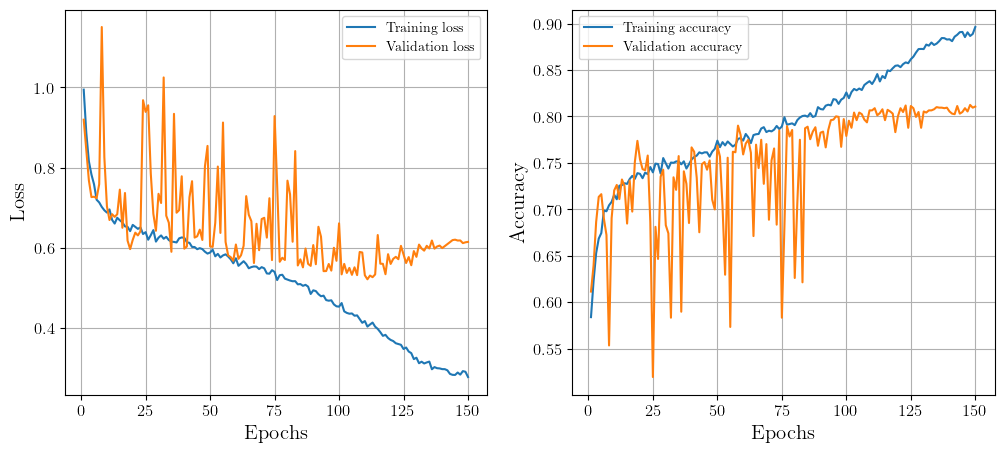

In [13]:
epochs = np.arange(1, 151)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(epochs, loss_train, label='Training loss')
ax[0].plot(epochs, loss_valid, label='Validation loss')
ax[0].set_xlabel('Epochs', fontsize=15)
ax[0].set_ylabel('Loss', fontsize=15)

ax[1].plot(epochs, acc_train, label='Training accuracy')
ax[1].plot(epochs, acc_valid, label='Validation accuracy')
ax[1].set_xlabel('Epochs', fontsize=15)
ax[1].set_ylabel('Accuracy', fontsize=15)

ax[0].grid('on')
ax[1].grid('on')

ax[0].legend()
ax[1].legend()

#plt.savefig('./../results/hamilton_filter/history_adamoptim_alexnet_batchsize64.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Saving model

#torch.save(model.state_dict(), './../saved/afibclass_adamoptim_alexnet_batchsize16.pth')

However, the accuracy score is not always the best predictor of performance for classification tasks. Hence, it is important to assess other metrics such as precision, recall and the $F_1$ scores of the different classes. First, the confusion matrix is calculated and plotted as a heatmap.

In [14]:
@torch.no_grad()
def get_confusion_matrix(valid_dl, model):
    # Defining a function for calculating the confusion matrix
    # Require the total number of true and prediction labels in each category

    all_preds = torch.Tensor([])

    for image, label in valid_dl:

        output = model(image)

        all_preds = torch.cat((all_preds, output.data), dim=0) # vertically stacks all outputs from iterations

    '''
    Converting the PyTorch tensors into numpy arrays
    '''
    all_preds = torch.max(all_preds, dim=1).indices.numpy()
    all_labels = label_list.iloc[idx_test, 2].to_numpy()
    
    return confusion_matrix(all_labels, all_preds)

CM = get_confusion_matrix(valid_dl, model)

print(CM)

[[ 90  13  38   4]
 [  9 907  73   8]
 [ 27 125 344  11]
 [  4  10   1  42]]


Since the train/test split was not stratified, it can be seen that the validation set is over represented by normal rhythm examples, on which it performs very well. Interestingly, a significant number of 'Normal' rhythms are classified as 'Other/Unclassified', which might arise from inherent similarities between them.

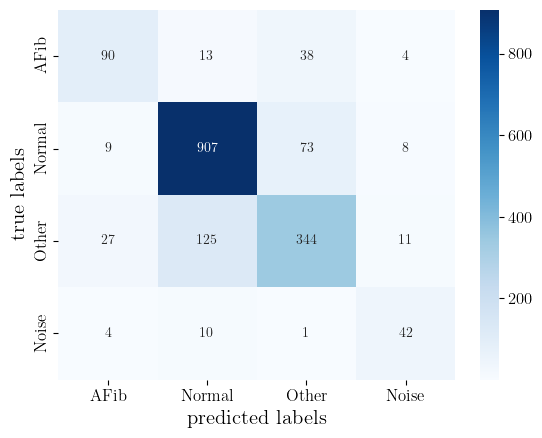

In [17]:
class_labels = ['AFib', 'Normal', 'Other', 'Noise']

sns.heatmap(CM, annot=True, fmt='.3g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel(r'predicted labels', fontsize=15)
plt.ylabel(r'true labels', fontsize=15)
#plt.savefig('./../results/hamilton_filter/CM_adam_optim_alexnet_batchsize64.png', dpi=300, bbox_inches='tight')
plt.show()

For a multiclass dataset, the precision and recall values can be best calculated using the confusion matrix. In a confusion matrix, the $y$-axis represents the true labels while the $x$ represents the predictions. Let $C_{ij}$ represent the elements of the confusion matrix. Then
$$ \text{Precision}_i = \frac{C_{ii}}{\sum_{i} C_{ij}},\;\;\;\;\; \text{Recall}_i = \frac{C_{ii}}{\sum_{j}C_{ij}} $$
where $i$ is the class label.

In [16]:
def F1_score(CM, class_label):
    '''
    This function returns the F1 score associated with a particular class label.
    0 - AFib, 1 - Normal, 2 - Other, 3 - Noise
    '''
    keys = {
        'AFib'   : 0,
        'Normal' : 1,
        'Other'  : 2,
        'Noise'  : 3
    }
    key = keys[class_label]

    precision = CM[key, key] / CM[key, :].sum()
    recall = CM[key, key] / CM[:, key].sum()
    F1_score = 2*precision*recall / (precision + recall)

    return F1_score 

F1_AFib = F1_score(CM, 'AFib')
F1_Normal = F1_score(CM, 'Normal')
F1_Other = F1_score(CM, 'Other')
F1_Noise = F1_score(CM, 'Noise')
F1_overall = 0.25*(F1_AFib + F1_Normal + F1_Other + F1_Noise)
accuracy_score = np.trace(CM)/np.sum(CM)

print(f'F1 score for AFib: {F1_AFib}')
print(f'F1 score for Normal: {F1_Normal}')
print(f'F1 score for Other: {F1_Other}')
print(f'F1 score for Noise: {F1_Noise}')

print(f'Overall F1 score: {F1_overall}')
print(f'Accuracy score: {accuracy_score}')

F1 score for AFib: 0.6545454545454545
F1 score for Normal: 0.8840155945419104
F1 score for Other: 0.7144340602284528
F1 score for Noise: 0.6885245901639344
Overall F1 score: 0.735379924869938
Accuracy score: 0.8106682297772567


In [19]:
def prediction_stats(CM):
    ''' 
    This function uses the confusion matrix and produces the precision, recall and F1 scores of each category.
    The scores are then returned as a dataframe for better readability.
    '''
    keys = {
        'AFib'   : 0,
        'Normal' : 1,
        'Other'  : 2,
        'Noise'  : 3
    }
    precision_list = []
    recall_list = []
    F1_list = []

    for key, val in keys.items():
        precision = CM[val, val] / CM[val, :].sum()
        precision_list.append(precision)
        recall = CM[val, val] / CM[:, val].sum()
        recall_list.append(recall)
        f1 = 2*precision*recall / (precision + recall)
        F1_list.append(f1)

    stats_dict = {'Precision' : precision_list, 'Recall': recall_list, 'F1_score': F1_list}
    stats_df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['AFib', 'Normal', 'Other', 'Noise'])

    return stats_df 

stats_df = prediction_stats(CM)

stats_df 

,AFib,Normal,Other,Noise
Precision,0.620690,0.909729,0.678501,0.736842
Recall,0.692308,0.859716,0.754386,0.646154
F1_score,0.654545,0.884016,0.714434,0.688525


In [20]:
#stats_df.to_csv('./../results/hamilton_filter/stats_adam_optim_alexnet_batchsize64.csv')